## Introduction
 This code is part of a broader research project on surrogate modeling for multi-objective variability estimation. In this version, we implement a non-parametric surrogate based on a Radial Basis Function combined with Inverse Distance Weighting (RBF-IDW). This approach is inspired by [1]. It implements a pipeline to train and iteratively refine a surrogate model—specifically,a Radial Basis Function combined with Inverse Distance Weighting (RBF-IDW).

[1] Y. Liu, H. Fang and F. Li, "An Expensive Multi-Objective Evolutionary Algorithm with RBF-IDW Surrogate Model," 2024 International Conference on New Trends in Computational Intelligence (NTCI), Qingdao, China, 2024, pp. 86-90, doi: 10.1109/NTCI64025.2024.10776091.

In [15]:
import numpy as np
from pymoo.problems.many import DTLZ2
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Step 1 :Problem Definition
# Define the multi-objective benchmark problem DTLZ2.
n_obj = 3
k = 20
n_vars = n_obj + k - 1
problem = DTLZ2(n_var=n_vars, n_obj=n_obj)

# Define scalarized objective function based on user preference vector λ
def scalarized_objective(x, lam, problem):
    f = problem.evaluate(np.array([x]))[0]
    return np.dot(lam, f)

# Step 2: Load and preprocess data
# Load and clean dataset, scale the data, and split into training and test sets.
df = pd.read_csv("dtlz2_surrogate_dataset_extended_updated.csv")
df = df.dropna(subset=["frob_norm"])

# Feature and target selection
X = df[["lambda_1", "lambda_2", "lambda_3"]].values
y = df["frob_norm"].values.reshape(-1, 1)

# Normalization
X_scaler = StandardScaler().fit(X)
y_scaler = StandardScaler().fit(y)
X_scaled = X_scaler.transform(X)
y_scaled = y_scaler.transform(y).ravel()

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)


[RBF-IDW Surrogate Performance]
RMSE: 0.26030613360439375
R2: -0.24545577831208898


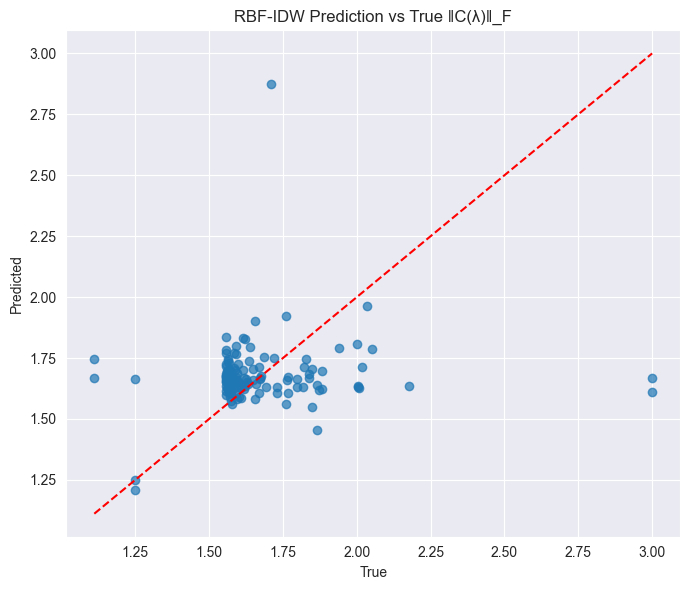

In [16]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from scipy.spatial.distance import cdist

# Step 3: RBF-IDW Surrogate
def rbf_idw_predict(X_train, y_train, X_test, p=2, epsilon=1e-8):
    distances = cdist(X_test, X_train) + epsilon  # shape (n_query, n_train)
    weights = 1.0 / np.power(distances, p)         # IDW weighting
    weights /= np.sum(weights, axis=1, keepdims=True)
    predictions = np.dot(weights, y_train)
    return predictions

# Fit: RBF-IDW is non-parametric, so just store training data
y_pred_scaled = rbf_idw_predict(X_train, y_train, X_test)
y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_pred_inv = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()


# Step 4: Model evaluation
print("[RBF-IDW Surrogate Performance]")
print("RMSE:", np.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))
print("R2:", r2_score(y_test_inv, y_pred_inv))

# Plot prediction vs true
plt.figure(figsize=(7, 6))
plt.scatter(y_test_inv, y_pred_inv, alpha=0.7, label="RBF-IDW")
plt.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], 'r--')
plt.title("RBF-IDW Prediction vs True ‖C(λ)‖_F")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()



The results shown in the plot and printed output reveal a limited predictive accuracy of the RBF-IDW surrogate on the task of estimating the Frobenius norm ‖C(λ)‖ₙ of the local covariance matrix. The surrogate fails to capture true variability trends across λ.
RBF-IDW is fast and simple, but without adaptive weighting or parameter tuning, its accuracy on structural features like ∥C(λ)∥_F remains limited as highlighted in [1].



In [17]:
#  Uncertainty for new λ candidates is estimated as the mean distance to the k-nearest λs in the training set.
def expected_uncertainty_rbf(X_train, X_query, k=5):
    distances = cdist(X_query, X_train)
    nearest_dists = np.sort(distances, axis=1)[:, :k]  # k nearest distances
    uncertainty = np.mean(nearest_dists, axis=1)
    return uncertainty

In [18]:
# Step 4: Active Sampling via Uncertainty
# λ vectors with the highest uncertainty are selected for evaluation.
def select_uncertain_lambdas(dataset_path, n_samples=1000, top_k=10):
    df = pd.read_csv(dataset_path)
    X = df[[col for col in df.columns if col.startswith("lambda_")]].values
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)

    # Candidate λ generation
    candidates = np.random.dirichlet(np.ones(3), size=n_samples)
    candidates_scaled = scaler.transform(candidates)

    # Compute uncertainty
    uncertainties = expected_uncertainty_rbf(X_scaled, candidates_scaled, k=5)
    top_indices = np.argsort(-uncertainties)[:top_k]

    selected_lambdas = candidates[top_indices]
    print("\nTop λ selected with highest uncertainty:")
    print(selected_lambdas)
    return selected_lambdas

In [19]:
from scipy.optimize import minimize

# Step 5: Update Dataset with new data
# Implement an iterative update of the RBF-IDW model with new candidate solutions selected via Expected Uncertainty.
def update_rbf_with_new_data(lambda_selected, dataset_path, problem, window_size=10):
    dataset = pd.read_csv(dataset_path)
    n_vars = len([col for col in dataset.columns if col.startswith("x_star_")])
    n_obj = len([col for col in dataset.columns if col.startswith("lambda_")])

    new_x_star, new_frob_norms, new_variances, new_P_vectors = [], [], [], []
    for lam in lambda_selected:
        res = minimize(scalarized_objective, x0=np.full(n_vars, 0.5), args=(lam, problem), method='L-BFGS-B', bounds=[(0.0, 1.0)] * n_vars)
        x_opt = res.x
        new_x_star.append(x_opt)

        if len(new_x_star) >= 2:
            X_local = StandardScaler().fit_transform(np.array(new_x_star[-window_size:]))
            C = np.cov(X_local.T) + np.eye(n_vars) * 1e-8
            new_frob_norms.append(np.linalg.norm(C, ord='fro'))
            new_variances.append(np.var(X_local, axis=0))
            P = np.linalg.cholesky(C)
            new_P_vectors.append(P[np.tril_indices_from(P)])
        else:
            new_frob_norms.append(np.nan)
            new_variances.append(np.full(n_vars, np.nan))
            new_P_vectors.append(np.full((n_vars * (n_vars + 1)) // 2, np.nan))

    new_data_dict = {f"lambda_{i+1}": lambda_selected[:, i] for i in range(n_obj)}
    new_data_dict["frob_norm"] = new_frob_norms
    for i in range(n_vars):
        new_data_dict[f"x_star_{i+1}"] = [x[i] for x in new_x_star]
        new_data_dict[f"var_x_star_{i+1}"] = [v[i] for v in new_variances]
    for i in range(len(new_P_vectors[0])):
        new_data_dict[f"P_vec_{i+1}"] = [p[i] for p in new_P_vectors]
    new_data_dict["source"] = ["EI_selected"] * len(lambda_selected)

    new_df = pd.DataFrame(new_data_dict)
    updated_dataset = pd.concat([dataset, new_df], ignore_index=True).dropna(subset=["frob_norm"])
    updated_dataset.to_csv(dataset_path, index=False)

    X = updated_dataset[[f"lambda_{i+1}" for i in range(n_obj)]].values
    y = updated_dataset["frob_norm"].values.reshape(-1, 1)

    X_scaler = StandardScaler().fit(X)
    y_scaler = StandardScaler().fit(y)
    X_scaled = X_scaler.transform(X)
    y_scaled = y_scaler.transform(y).ravel()

    split = int(0.8 * len(X_scaled))
    X_train, X_test = X_scaled[:split], X_scaled[split:]
    y_train, y_test = y_scaled[:split], y_scaled[split:]

    def rbf_idw_predict(X_train, y_train, X_query, p=2, epsilon=1e-8):
        distances = cdist(X_query, X_train) + epsilon
        weights = 1.0 / np.power(distances, p)
        weights /= np.sum(weights, axis=1, keepdims=True)
        return np.dot(weights, y_train)

    y_pred_scaled = rbf_idw_predict(X_train, y_train, X_test)
    y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
    y_pred_inv = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    print("[RBF-IDW Surrogate Performance - Updated]")
    print("RMSE:", np.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))
    print("R2:", r2_score(y_test_inv, y_pred_inv))

    plt.figure(figsize=(7, 6))
    plt.scatter(y_test_inv, y_pred_inv, alpha=0.7)
    plt.plot([y_test_inv.min(), y_test_inv.max()], [y_test_inv.min(), y_test_inv.max()], 'r--')
    plt.title("RBF-IDW Prediction vs True ‖C(λ)‖_F")
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return updated_dataset



Top λ selezionati per distanza media (proxy incertezza):
[[1.74301901e-02 2.40105475e-03 9.80168755e-01]
 [8.34076224e-03 1.11100614e-02 9.80549176e-01]
 [2.58937975e-03 1.85129705e-02 9.78897650e-01]
 [5.79539285e-03 2.82754368e-02 9.65929170e-01]
 [1.37263554e-02 2.39877885e-02 9.62285856e-01]
 [7.76819113e-03 3.07366287e-02 9.61495180e-01]
 [6.16290383e-02 2.93821221e-04 9.38077140e-01]
 [8.78921699e-04 1.59028170e-01 8.40092908e-01]
 [4.44316763e-02 1.07455738e-02 9.44822750e-01]
 [6.51282427e-01 3.45852234e-01 2.86533885e-03]]
[RBF-IDW Surrogate Performance - Updated]
RMSE: 0.5336537172731145
R2: -0.0023717882491820497


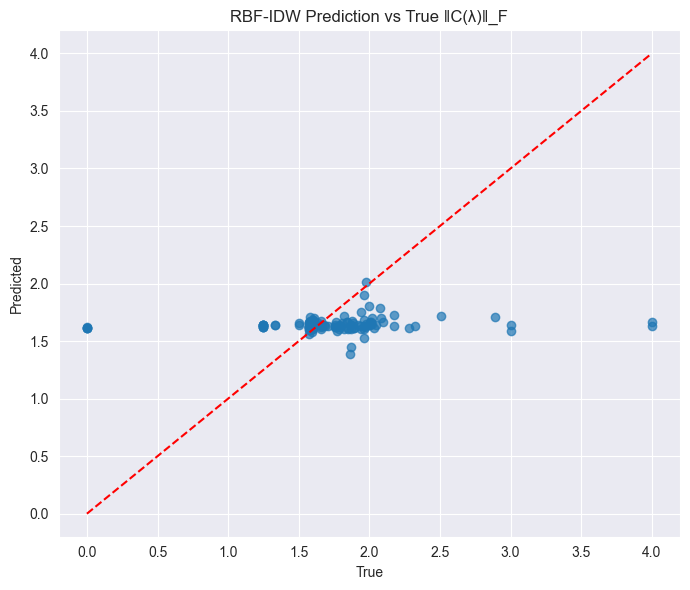

In [20]:

lambda_selected = select_uncertain_lambdas(
    dataset_path="dtlz2_surrogate_dataset_extended_updated.csv",
    n_samples=1000,   # numero candidati generati casualmente
    top_k=10          # numero λ selezionati con incertezza maggiore
)
dataset_path = "dtlz2_surrogate_dataset_extended_updated.csv"
updated_dataset = update_rbf_with_new_data(
    lambda_selected=lambda_selected,
    dataset_path="dtlz2_surrogate_dataset_extended_updated.csv",
    problem=problem,
    window_size=5
)

After applying the active sampling step based on uncertainty (mean distance) and updating the dataset with new evaluations of the top 10 λ vectors, the surrogate performance shows limited improvement.